In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the data
df = pd.read_csv('GartnerData.csv', sep='|', lineterminator='\n', header=0)
df = df.drop_duplicates()
print(df)

     Rate          Date                                       Product_Name  \
0     5.0  Mar 24, 2023                              Talend Data Inventory   
1     5.0   Apr 8, 2022                                 Talend Data Fabric   
2     5.0   Apr 4, 2023                                 Talend Data Fabric   
3     4.0   Mar 6, 2023                                    Talend Big Data   
4     4.0  Mar 24, 2023                                    Talend Big Data   
..    ...           ...                                                ...   
423   4.0  Oct 31, 2019                                 Talend Data Fabric   
444   5.0  Apr 30, 2019  Talend Platform for Big Data Integration (Legacy)   
453   5.0  Oct 23, 2018                                 Talend Data Fabric   
455   4.0  Oct 26, 2018                                 Talend Data Fabric   
488   3.0  Mar 21, 2017                                 Talend Data Fabric   

          User_Function                          Company_Size  

# Analyse des sentiments

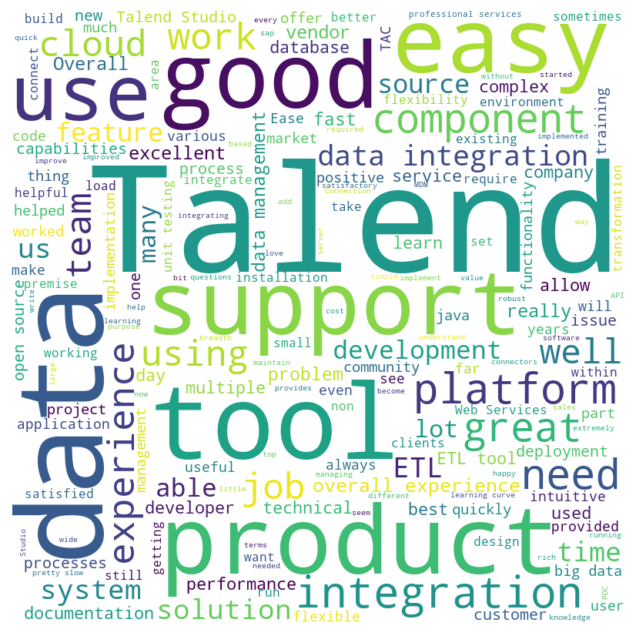

In [30]:
# Combine all the text data into a single string
text = ' '.join(df['Text'].tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# Display the WordCloud
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# Show the plot
plt.show()

In [31]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [32]:
# Compute the sentiment scores for each row in the Text column
df['Sentiment'] = df['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
# Create a new column with sentiment categories
df['Sentiment_Category'] = pd.cut(df['Sentiment'], bins=[-1, -0.33, 0.33, 1], labels=['Negative', 'Neutral', 'Positive'])
print(df)

# export the dataframe to a CSV file
df.to_csv('Reviews.csv', index=False)

     Rate          Date                                       Product_Name  \
0     5.0  Mar 24, 2023                              Talend Data Inventory   
1     5.0   Apr 8, 2022                                 Talend Data Fabric   
2     5.0   Apr 4, 2023                                 Talend Data Fabric   
3     4.0   Mar 6, 2023                                    Talend Big Data   
4     4.0  Mar 24, 2023                                    Talend Big Data   
..    ...           ...                                                ...   
423   4.0  Oct 31, 2019                                 Talend Data Fabric   
444   5.0  Apr 30, 2019  Talend Platform for Big Data Integration (Legacy)   
453   5.0  Oct 23, 2018                                 Talend Data Fabric   
455   4.0  Oct 26, 2018                                 Talend Data Fabric   
488   3.0  Mar 21, 2017                                 Talend Data Fabric   

          User_Function                          Company_Size  

In [33]:
# Compute descriptive statistics for the sentiment scores
stats = df['Sentiment'].describe()

# Print the descriptive statistics
print(stats)

count    187.000000
mean       0.537632
std        0.404088
min       -0.731100
25%        0.378100
50%        0.690100
75%        0.829350
max        0.947600
Name: Sentiment, dtype: float64


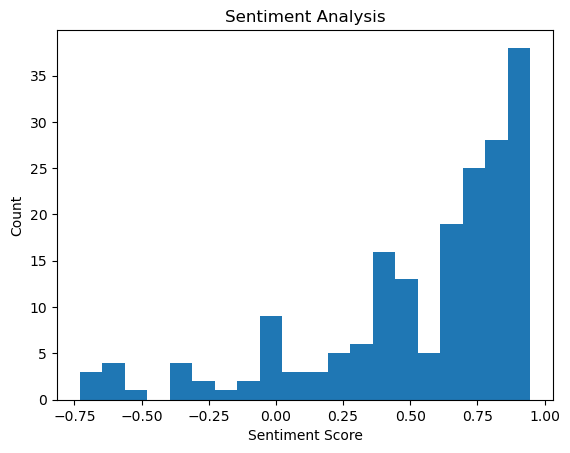

In [34]:
# Ajouter un titre
plt.title('Distribution des sentiments')

# Create a histogram of the sentiment scores
plt.hist(df['Sentiment'], bins=20)
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

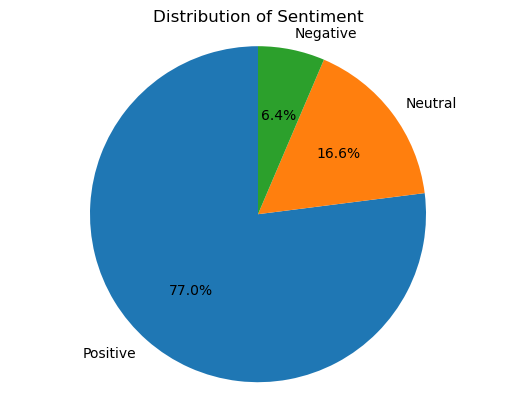

In [35]:
# Count the number of occurrences of each sentiment category
sentiment_counts = df['Sentiment_Category'].value_counts()

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Distribution of Sentiment')

# Show the pie chart
plt.show()

# Sentiment & Rating

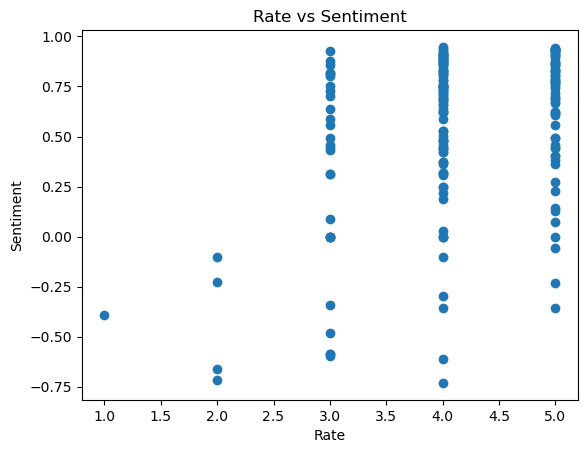

In [36]:
# Create a scatterplot of rate vs sentiment
fig, ax = plt.subplots()
ax.scatter(df['Rate'], df['Sentiment'])
ax.set_xlabel('Rate')
ax.set_ylabel('Sentiment')
ax.set_title('Rate vs Sentiment')
plt.show()

# Sentiment by Industry

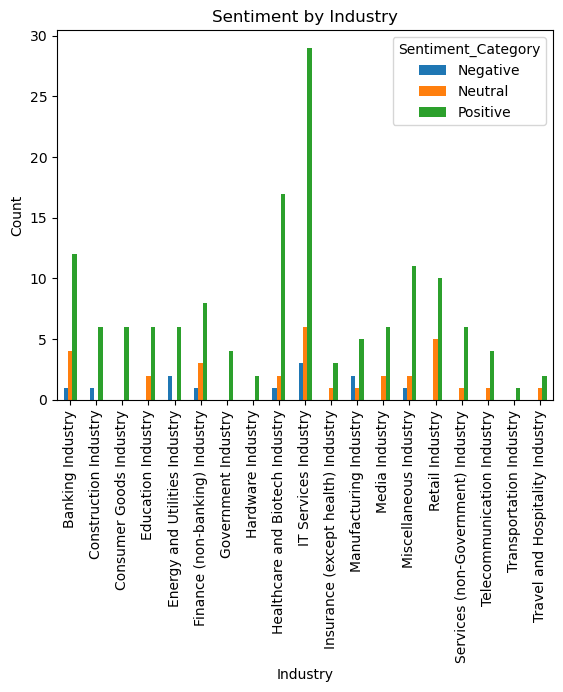

In [37]:
# Group the data by industry and sentiment_category
grouped = df.groupby(['Industry', 'Sentiment_Category'])

# Count the number of products in each category
counts = grouped.size().reset_index(name='Count')

# Create a bar chart
fig, ax = plt.subplots()
counts.pivot(index='Industry', columns='Sentiment_Category', values='Count').plot(kind='bar', ax=ax)
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.set_title('Sentiment by Industry')
plt.show()

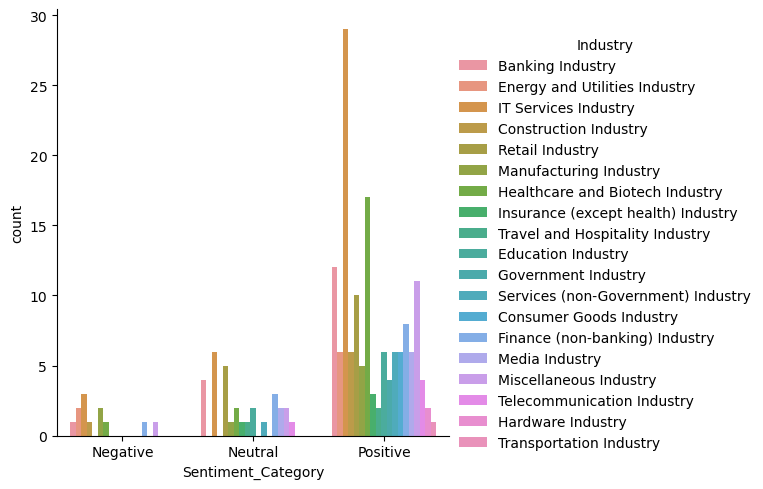

In [38]:
import seaborn as sns

# Create a bar chart of sentiment by industry
sns.catplot(x='Sentiment_Category', kind='count', hue='Industry', data=df)


# Popolarité des Produits de Talend

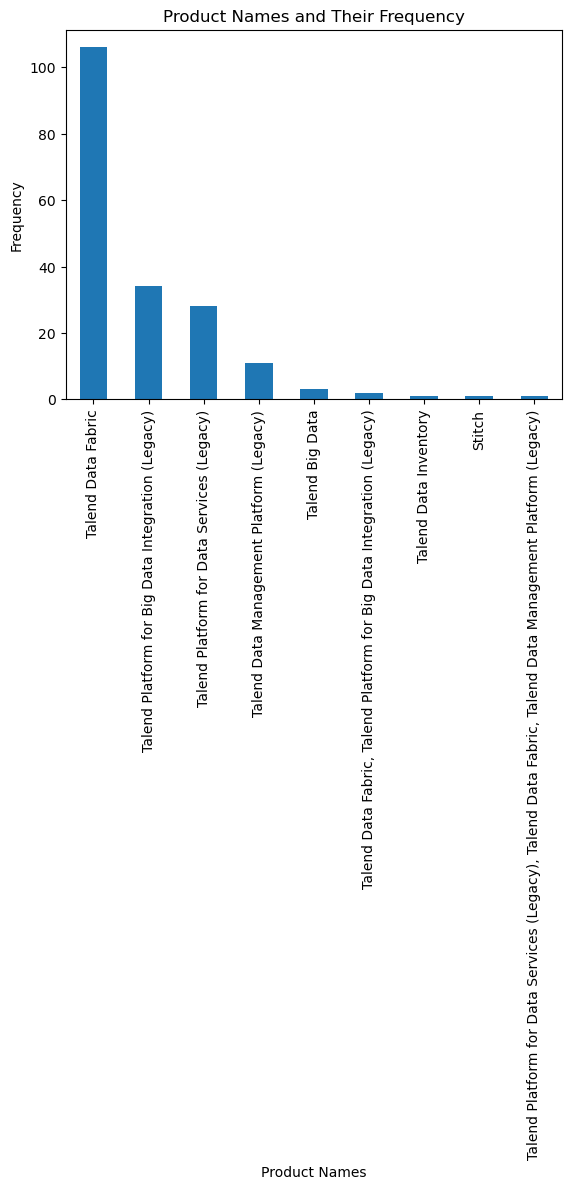

In [39]:
# Get the frequency of each product name in the DataFrame
product_counts = df['Product_Name'].value_counts()

# Create a bar chart to show the frequency of each product name
fig, ax = plt.subplots()
product_counts.plot.bar(ax=ax)
ax.set_title('Product Names and Their Frequency')
ax.set_xlabel('Product Names')
ax.set_ylabel('Frequency')
plt.show()


# Distribution des sentiments par produit

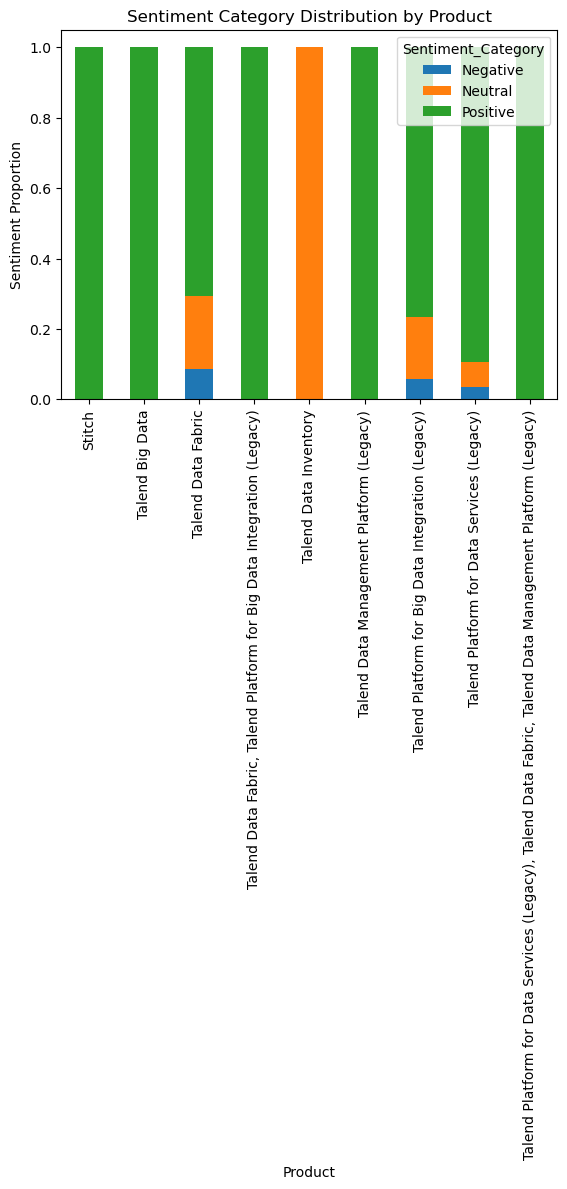

In [40]:
# Group by product and sentiment, and count the number of occurrences
sentiment_counts = df.groupby(['Product_Name', 'Sentiment_Category'])['Sentiment_Category'].count().unstack()

# Normalize the counts by row to get the proportion of each sentiment for each product
sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Plot a stacked bar chart of the sentiment proportions by product
sentiment_props.plot(kind='bar', stacked=True)

# Set the chart title and axis labels
plt.title('Sentiment Category Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Sentiment Proportion')

# Show the chart
plt.show()

# Top words for each product

In [41]:
# Preprocess the text
df['Text'] = df['Text'].str.lower()
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split()]))

# Create a matrix of word frequencies
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])

# Get the most common words for each product
for i, product in enumerate(df['Product_Name'].unique()):
    indices = (df['Product_Name'] == product).to_numpy().nonzero()[0]
    top_words = Counter([word for j in X[indices].toarray() for word, freq in zip(vectorizer.vocabulary_.keys(), j) for _ in range(freq)]).most_common(10)
    print(f"Product: {product}")
    print(f"Top words: {', '.join([word for word, freq in top_words])}")
    print()

Product: Talend Data Inventory
Top words: active, single, always, us, in, now, mort, getting, migrate, based

Product: Talend Data Fabric
Top words: asked, enough, always, recommend, active, expertise, complete, affecting, notch, familiar

Product: Talend Big Data
Top words: active, expertise, kafka, enough, always, complete, did, asked, affecting, learn

Product: Talend Platform for Data Services (Legacy)
Top words: asked, enough, recommend, expertise, always, affecting, active, complete, kafka, notch

Product: Stitch
Top words: always, deployment, complete, movement, positive, active, userfriendly, recommend, warranty, applicatiojn

Product: Talend Data Management Platform (Legacy)
Top words: complete, enough, always, expertise, asked, feels, recommend, notch, us, familiar

Product: Talend Platform for Big Data Integration (Legacy)
Top words: asked, always, enough, active, expertise, recommend, kafka, responsive, affecting, expereince

Product: Talend Platform for Data Services (Lega

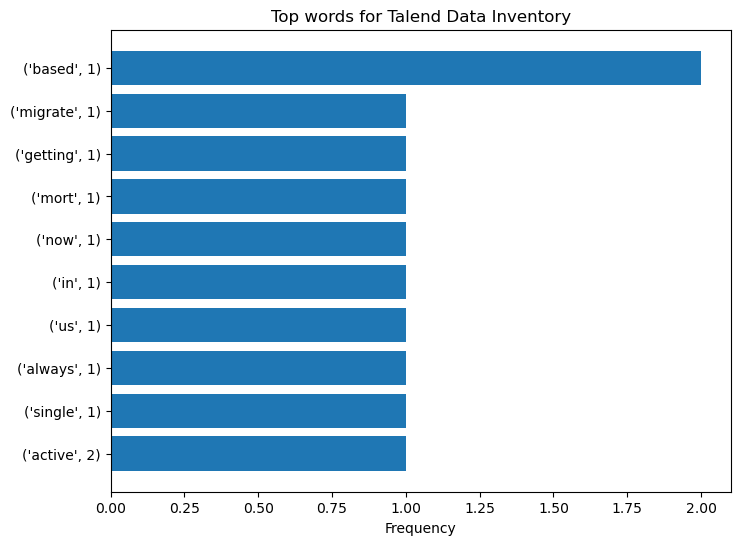

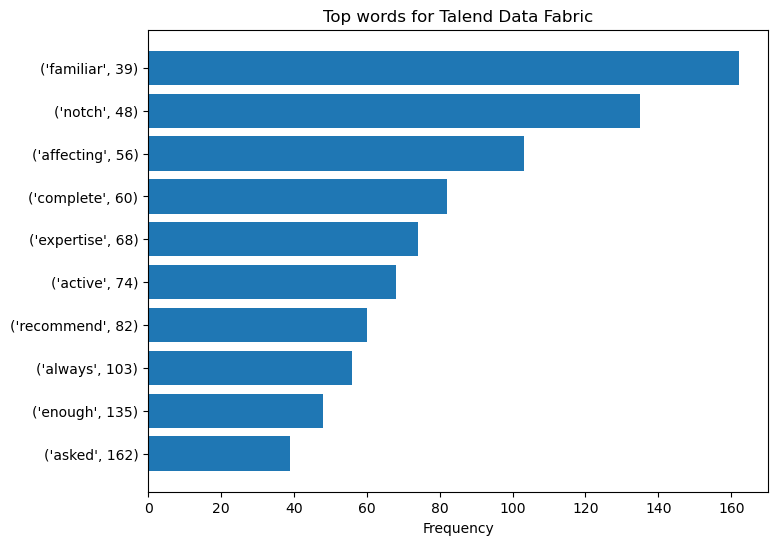

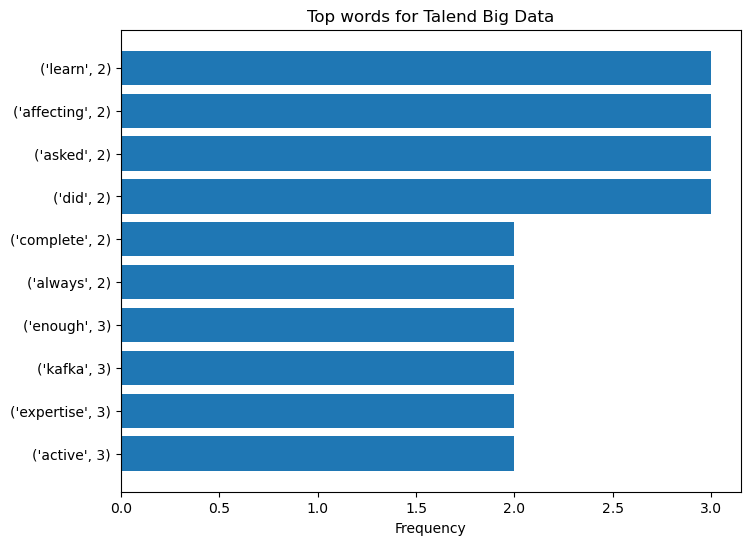

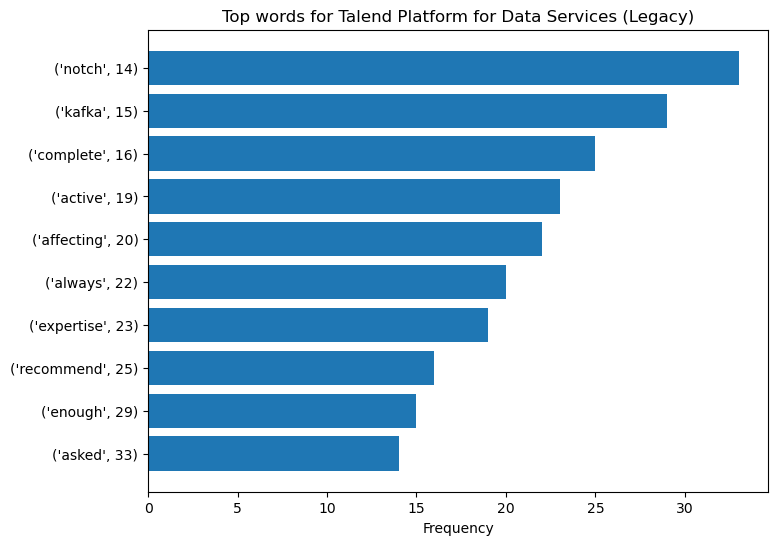

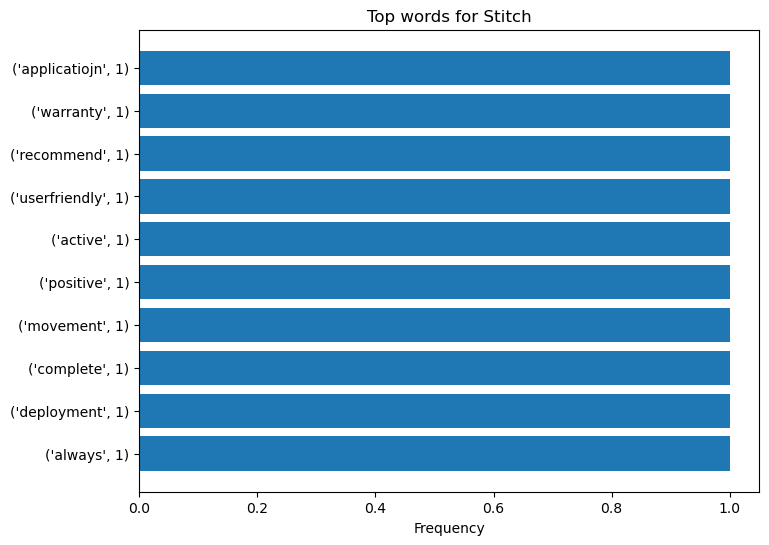

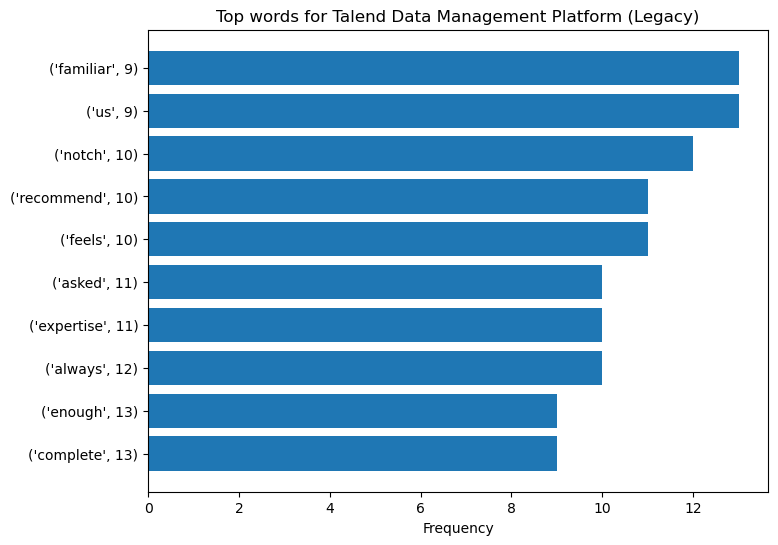

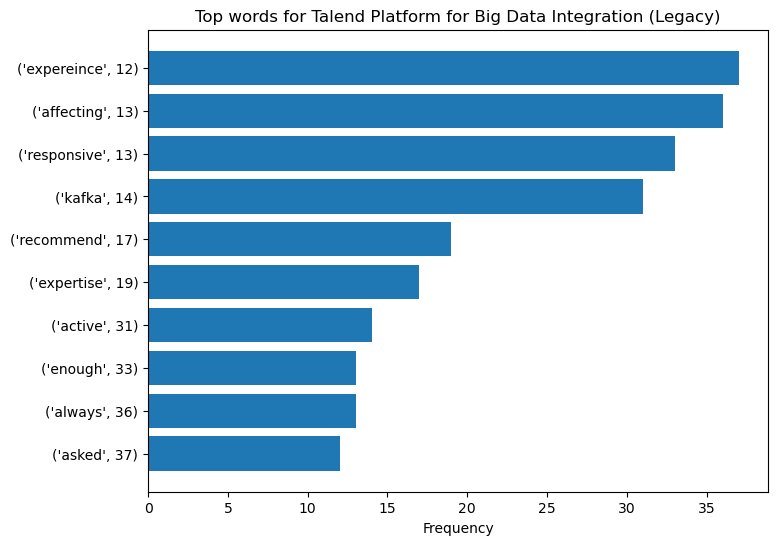

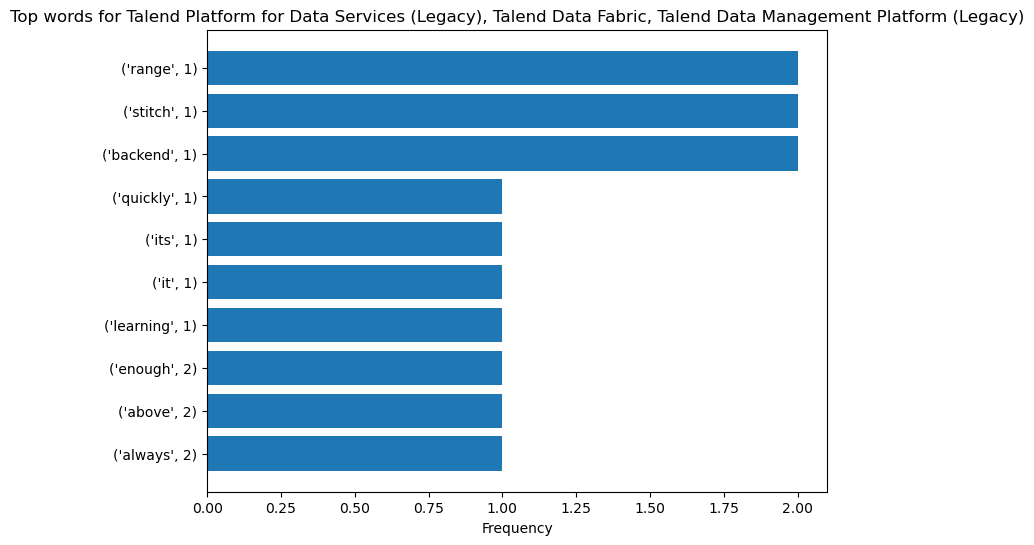

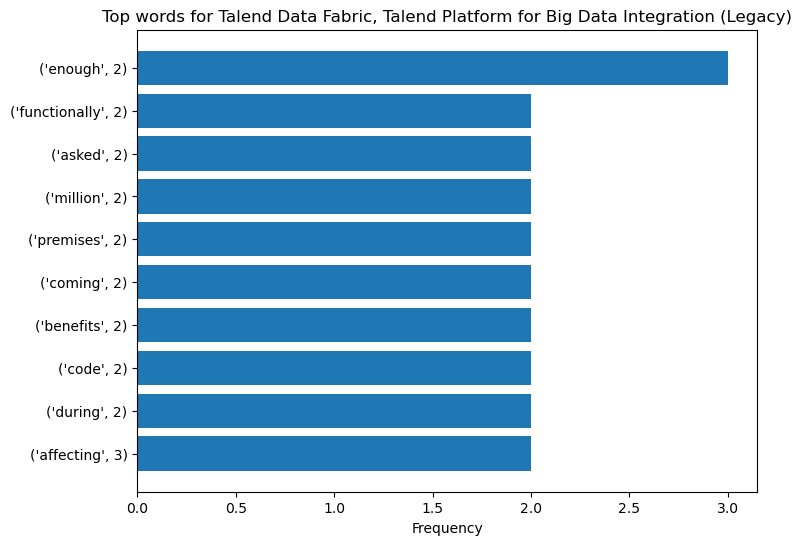

In [42]:
# Preprocess the text
df['Text'] = df['Text'].str.lower()
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split()]))

# Create a matrix of word frequencies
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])

# Get the most common words for each product
for i, product in enumerate(df['Product_Name'].unique()):
    indices = (df['Product_Name'] == product).to_numpy().nonzero()[0]
    top_words = Counter([word for j in X[indices].toarray() for word, freq in zip(vectorizer.vocabulary_.keys(), j) for _ in range(freq)]).most_common(10)
    top_word_counts = [X[indices].toarray()[:,j].sum() for j in X[indices].toarray().sum(axis=0).argsort()[::-1][:10]][::-1]
    y_pos = np.arange(len(top_words))

    plt.figure(figsize=(8,6))
    plt.barh(y_pos, top_word_counts, align='center')
    plt.yticks(y_pos, top_words)
    plt.xlabel('Frequency')
    plt.title(f'Top words for {product}')
    plt.show()